##PERSIAPAN LIBRARY

In [1]:
!pip install Transformers

In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.

In [3]:
import os
import tensorflow as tf
import keras
import re
import pandas as pd
import numpy as np
import sklearn
import torch
import pickle
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras.layers import MultiHeadAttention, Input, Dense
from tensorflow.keras.layers import LayerNormalization, Layer
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D

from tensorflow.data import Dataset
from tensorflow import convert_to_tensor, string, float32, shape, range, reshape
from tensorflow.keras import utils

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, Reshape

from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from transformers import BertTokenizer, TFBertForSequenceClassification, Trainer, TrainingArguments
from evaluate import load

from imblearn.over_sampling import SMOTE

##PERSIAPAN DATASET (MOUNT GDRIVE)

In [5]:
df_train = pd.read_excel("/content/drive/MyDrive/BPS_PROJECT/PRE-PROCESSED/labeled.xlsx")

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1550 entries, 0 to 1549
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   placeId              1550 non-null   object 
 1   placeName            1550 non-null   object 
 2   placeAddress         1527 non-null   object 
 3   placeBusinessStatus  1550 non-null   object 
 4   placeTypes           1550 non-null   object 
 5   placeLatitude        1549 non-null   float64
 6   placeLongitude       1549 non-null   float64
 7   kbli                 1550 non-null   object 
dtypes: float64(2), object(6)
memory usage: 97.0+ KB


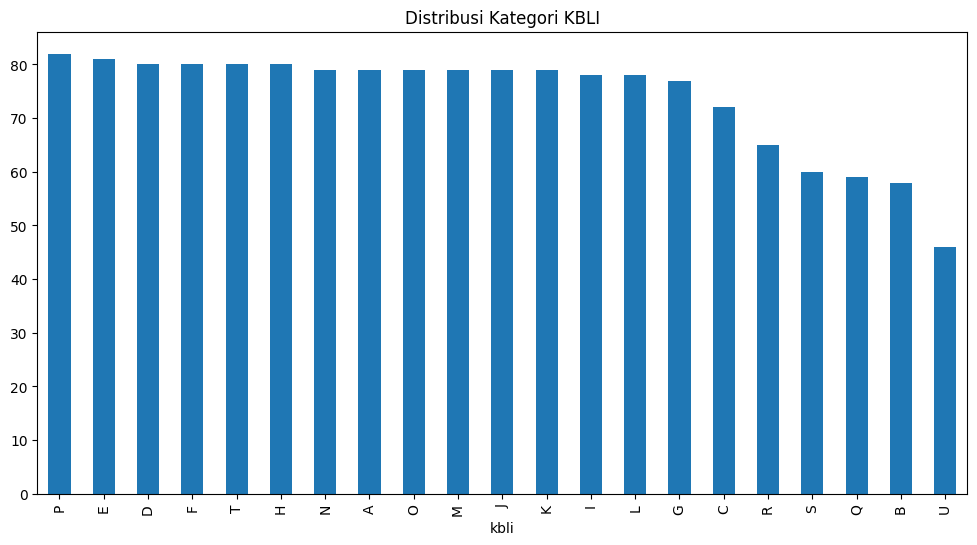

In [7]:
class_distribution = df_train['kbli'].value_counts()

plt.figure(figsize=(12,6))
class_distribution.plot(kind='bar')
plt.title("Distribusi Kategori KBLI")
plt.show()

In [8]:
class_counts = df_train['kbli'].value_counts()
print("Jumlah sampel per kelas:\n", class_counts)

Jumlah sampel per kelas:
 kbli
P    82
E    81
D    80
F    80
T    80
H    80
N    79
A    79
O    79
M    79
J    79
K    79
I    78
L    78
G    77
C    72
R    65
S    60
Q    59
B    58
U    46
Name: count, dtype: int64


In [9]:
df_train['placeAddress']=df_train['placeAddress'].fillna('-')

In [10]:
df_train['desc'] = df_train['placeName'] + df_train['placeTypes']

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_train['desc'] = df_train['desc'].apply(clean_text)

In [12]:
tfidf = TfidfVectorizer(max_features=2000)
X = tfidf.fit_transform(df_train['desc'])
y = df_train['kbli']

##SPLIT DATASET (TRAIN, TEST, VAL)

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

In [14]:
smote = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [15]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

X_train_float = X_train.toarray().astype('float32')
X_val_float = X_val.toarray().astype('float32')

##MODEL

In [16]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            accuracy = logs.get('accuracy')
            val_accuracy = logs.get('val_accuracy')
            if accuracy is not None and val_accuracy is not None:
                if accuracy >= 0.80 and val_accuracy >= 0.80:
                    self.model.stop_training = True
                    print("\nReached 80% train accuracy and 80% validation accuracy, so cancelling training!")

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('se_with_cnn.keras', save_best_only=True, monitor='val_accuracy', mode='max')

In [18]:
early_stopping = EarlyStoppingCallback()

### CNN

In [19]:
model_cnn = Sequential([
    Reshape((X_train_float.shape[1], 1), input_shape=(X_train_float.shape[1],)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(21, activation='softmax')
])
model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_cnn = model_cnn.fit(
    X_train_float, y_train_encoded,
    validation_data = (X_val_float, y_val_encoded),
    epochs = 20,
    batch_size = 32,
    callbacks=[early_stopping, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.1839 - loss: 2.9818 - val_accuracy: 0.7161 - val_loss: 2.1621
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7075 - loss: 1.6374 - val_accuracy: 0.8903 - val_loss: 0.6135
Epoch 3/20
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9566 - loss: 0.2730
Reached 80% train accuracy and 80% validation accuracy, so cancelling training!
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9565 - loss: 0.2704 - val_accuracy: 0.9161 - val_loss: 0.3888


### NN

In [20]:
model_nn = Sequential([
    Dense(256, activation='relu', input_shape = (X_train_float.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(21, activation='softmax')
])
model_nn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_nn = model_nn.fit(
    X_train_float, y_train_encoded,
    validation_data = (X_val_float, y_val_encoded),
    epochs = 20,
    batch_size = 32
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.1213 - loss: 3.0342 - val_accuracy: 0.4258 - val_loss: 2.9607
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4023 - loss: 2.8877 - val_accuracy: 0.5806 - val_loss: 2.5879
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6041 - loss: 2.3497 - val_accuracy: 0.7742 - val_loss: 1.7984
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8108 - loss: 1.4407 - val_accuracy: 0.8323 - val_loss: 1.1421
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9381 - loss: 0.7273 - val_accuracy: 0.8839 - val_loss: 0.7648
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9771 - loss: 0.3389 - val_accuracy: 0.9032 - val_loss: 0.6238
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9881 - loss: 0.2224 - val_accuracy: 0.9097 - val_loss: 0.5236
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9913 - loss: 0.1309 - val_accuracy: 0.9032 - val_loss: 0.4827
Ep

#HASIL TRAINING

##CNN

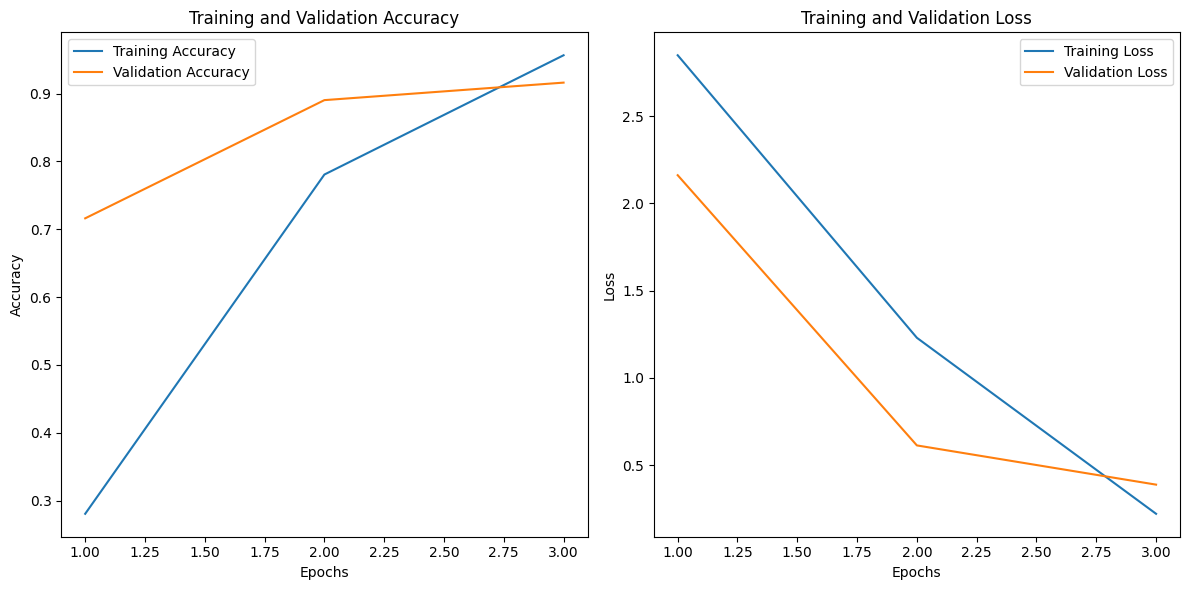

In [21]:
accuracy = history_cnn.history['accuracy']
val_accuracy = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


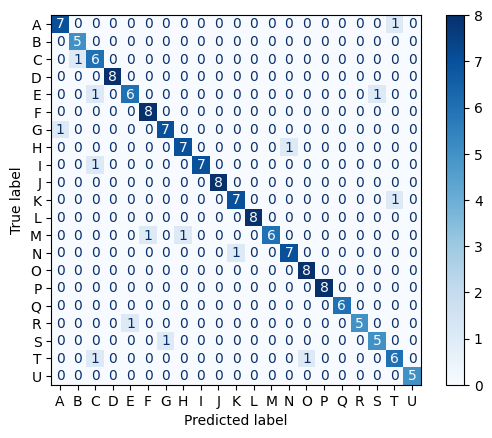

In [22]:
y_test_encoded = le.transform(y_test)
y_pred = model_cnn.predict(X_test.toarray()).argmax(axis=1)
cm = confusion_matrix(y_test_encoded, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.show()

In [23]:
X_test_float = X_test.toarray().astype('float32')
y_test_encoded = le.transform(y_test)

y_pred_prob = model_cnn.predict(X_test_float)
y_pred = y_pred_prob.argmax(axis=1)

f1 = f1_score(y_test_encoded, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
F1 Score: 0.9034

Classification Report:
              precision    recall  f1-score   support

           A       0.88      0.88      0.88         8
           B       0.83      1.00      0.91         5
           C       0.67      0.86      0.75         7
           D       1.00      1.00      1.00         8
           E       0.86      0.75      0.80         8
           F       0.89      1.00      0.94         8
           G       0.88      0.88      0.88         8
           H       0.88      0.88      0.88         8
           I       1.00      0.88      0.93         8
           J       1.00      1.00      1.00         8
           K       0.88      0.88      0.88         8
           L       1.00      1.00      1.00         8
           M       1.00      0.75      0.86         8
           N       0.88      0.88      0.88         8
           O       0.89      1.00      0.94         8
           P       1.00      1.00      1.00         8
  

In [24]:
X_test_float = X_test.toarray().astype('float32')
y_test_encoded = le.transform(y_test)

y_pred_probs = model_cnn.predict(X_test_float)
y_pred = y_pred_probs.argmax(axis=1)
confidence = y_pred_probs.max(axis=1)

results_df = pd.DataFrame({
    'original_label': le.inverse_transform(y_test_encoded),
    'predicted_label': le.inverse_transform(y_pred),
    'confidence': confidence
})

results_df.to_excel("test_predictions_cnn.xlsx", index=False)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


##NN

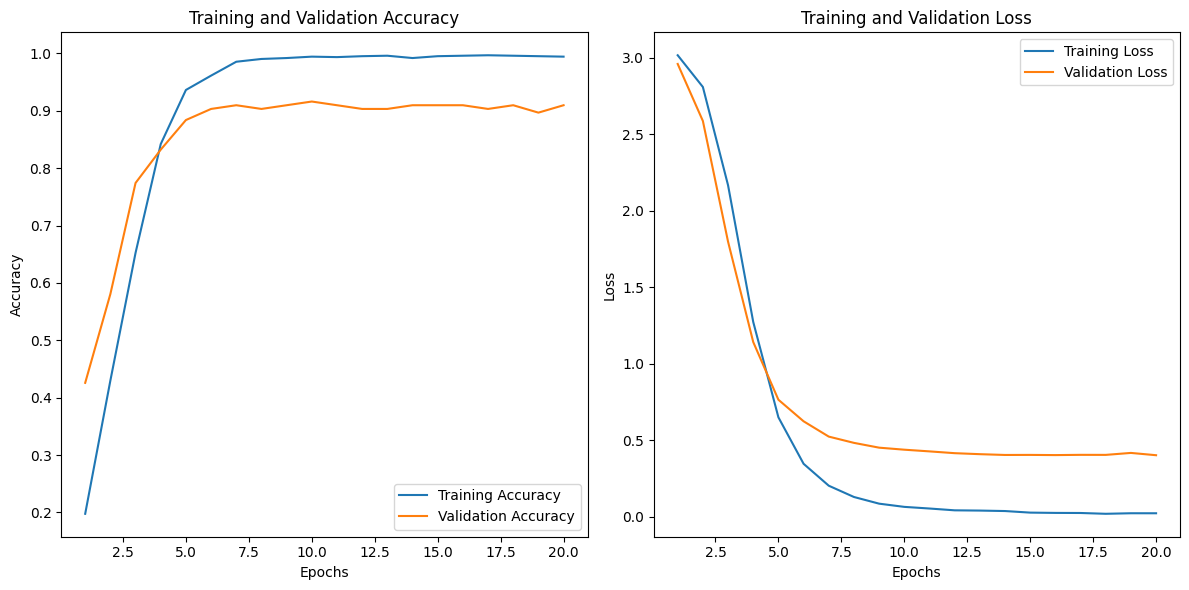

In [25]:
accuracy = history_nn.history['accuracy']
val_accuracy = history_nn.history['val_accuracy']
loss = history_nn.history['loss']
val_loss = history_nn.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


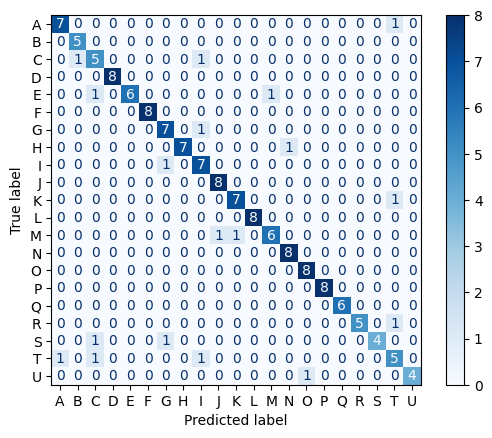

In [26]:
y_test_encoded = le.transform(y_test)
y_pred = model_nn.predict(X_test.toarray()).argmax(axis=1)
cm = confusion_matrix(y_test_encoded, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.show()

In [27]:
X_test_float = X_test.toarray().astype('float32')
y_test_encoded = le.transform(y_test)

y_pred_prob = model_nn.predict(X_test_float)
y_pred = y_pred_prob.argmax(axis=1)

f1 = f1_score(y_test_encoded, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
F1 Score: 0.8841

Classification Report:
              precision    recall  f1-score   support

           A       0.88      0.88      0.88         8
           B       0.83      1.00      0.91         5
           C       0.62      0.71      0.67         7
           D       1.00      1.00      1.00         8
           E       1.00      0.75      0.86         8
           F       1.00      1.00      1.00         8
           G       0.78      0.88      0.82         8
           H       1.00      0.88      0.93         8
           I       0.70      0.88      0.78         8
           J       0.89      1.00      0.94         8
           K       0.88      0.88      0.88         8
           L       1.00      1.00      1.00         8
           M       0.86      0.75      0.80         8
           N       0.89      1.00      0.94         8
           O       0.89      1.00      0.94         8
           P       1.00      1.00      1.00         8
  

In [28]:
X_test_float = X_test.toarray().astype('float32')
y_test_encoded = le.transform(y_test)

y_pred_probs = model_nn.predict(X_test_float)
y_pred = y_pred_probs.argmax(axis=1)
confidence = y_pred_probs.max(axis=1)

results_df = pd.DataFrame({
    'original_label': le.inverse_transform(y_test_encoded),
    'predicted_label': le.inverse_transform(y_pred),
    'confidence': confidence
})

results_df.to_excel("test_predictions_nn.xlsx", index=False)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


#Simpan Model (.h5 dan .savetensor)

In [29]:
model_cnn.save('/content/drive/MyDrive/BPS_PROJECT/MODEL/klbi_classification/klbi_class_cnn.keras')
model_cnn.save('/content/drive/MyDrive/BPS_PROJECT/MODEL/klbi_classification/klbi_class_cnn.h5')

model_nn.save('/content/drive/MyDrive/BPS_PROJECT/MODEL/klbi_classification/klbi_class_nn.keras')
model_nn.save('/content/drive/MyDrive/BPS_PROJECT/MODEL/klbi_classification/klbi_class_nn.h5')

In [30]:
with open("/content/drive/MyDrive/BPS_PROJECT/MODEL/klbi_classification/tfidf_vectorizer_cnn.pkl", "wb") as f:
    pickle.dump(tfidf, f)

#Apply Model Ke Dataset Full

In [31]:
df = pd.read_excel("/content/drive/MyDrive/BPS_PROJECT/PROCESSED/klbi_classification/COMBINED_DATASET.xlsx")

### CNN

In [32]:
model_cnn = load_model('/content/drive/MyDrive/BPS_PROJECT/MODEL/klbi_classification/klbi_class_cnn.h5')

In [33]:
with open("/content/drive/MyDrive/BPS_PROJECT/MODEL/klbi_classification/tfidf_vectorizer_cnn.pkl", "rb") as f:
    tfidf = pickle.load(f)

In [34]:
X_new = tfidf.transform(df['placeName'] + df['placeTypes'])
X_new_float = X_new.toarray().astype('float32')

In [35]:
y_new_probs = model_cnn.predict(X_new_float)
y_new_pred = y_new_probs.argmax(axis=1)

1355/1355 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


In [36]:
df['predicted_label'] = le.inverse_transform(y_new_pred)

In [37]:
df.to_excel("//content/drive/MyDrive/BPS_PROJECT/PROCESSED/klbi_classification/PREDICTED_ALL_82ACC_cnn.xlsx", index = False)

In [38]:
df.head(20)

,placeId,placeName,placeAddress,placeBusinessStatus,placeTypes,placeLatitude,placeLongitude,source,predicted_label
0,ChIJG0i9CEap1TERq1G-K3lxuus,Graha Renova,"GC2C+GP3, Tengkerang Barat",OPERATIONAL,"point_of_interest,establishment",0.501254,101.421803,GMAPS,J
1,ChIJI0kxnE-p1TERVzzCaVLc_-A,Putri Jaya Abadi. CV,"Jalan Musyawarah No.184, Labuh Baru Timur",OPERATIONAL,"furniture_store,home_goods_store,point_of_inte...",0.503969,101.423609,GMAPS,G
2,ChIJ75xs3BSp1TERjUD6T2Hr7MU,Warung Ojo Forget,"GC3G+GQ4, Jalan Soekarno-Hatta, Sidomulyo Timur",OPERATIONAL,"restaurant,point_of_interest,food,establishment",0.503770,101.426964,GMAPS,T
3,ChIJn_QB002p1TERjXQjpmobcjE,Batam Central Electronik,"Komplek Taman Anggrek Blok A4-6, Jl. Tuanku Ta...",OPERATIONAL,"electronics_store,point_of_interest,store,esta...",0.503697,101.428838,GMAPS,G
4,ChIJWxkAUdOp1TERTPhwfB11yBc,BOS (Bintang Oto Service),"Jalan Ikhlas, Labuh Baru Timur",OPERATIONAL,"car_repair,point_of_interest,establishment",0.505233,101.430264,GMAPS,S
5,ChIJGZ6fZWKp1TER1-ehi3TTs-M,Arjuna 51,"GC6F+7GC, Labuh Baru Timur",OPERATIONAL,"lodging,point_of_interest,establishment",0.510688,101.423754,GMAPS,C
6,ChIJ7z8NCnmp1TERBB6h6lgxpGk,Villa Garuda Mas C3 Mawar,"Villa, Jalan Garuda Mas Mawar No.C3, Labuh Bar...",OPERATIONAL,"point_of_interest,establishment",0.510855,101.425538,GMAPS,L
7,ChIJuwVlnjir1TERIrSo4VY6KJk,Laundry Sepatu Hotel Shoes Clean & treatment,Jalan Arjuna No.125,OPERATIONAL,"point_of_interest,establishment",0.508483,101.424036,GMAPS,I
8,ChIJ0cJza2mp1TERIuIVdKGyDS0,Vape Pink Store,"Jalan Eka Sari Jalan Arjuna No.56, Labuh Baru ...",OPERATIONAL,"point_of_interest,store,establishment",0.511309,101.424465,GMAPS,G
9,ChIJV698pw2p1TERYF4aEyoypYg,Bengkel Las Arjuna,"GC6F+GQG, Jalan Arjuna, Labuh Baru Timur",OPERATIONAL,"point_of_interest,establishment",0.511312,101.424466,GMAPS,F


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43343 entries, 0 to 43342
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   placeId              43343 non-null  object 
 1   placeName            43343 non-null  object 
 2   placeAddress         41352 non-null  object 
 3   placeBusinessStatus  43343 non-null  object 
 4   placeTypes           43343 non-null  object 
 5   placeLatitude        43343 non-null  float64
 6   placeLongitude       43343 non-null  float64
 7   source               43343 non-null  object 
 8   predicted_label      43343 non-null  object 
dtypes: float64(2), object(7)
memory usage: 3.0+ MB


### NN

In [40]:
model_nn = load_model('/content/drive/MyDrive/BPS_PROJECT/MODEL/klbi_classification/klbi_class_nn.h5')

In [41]:
with open("/content/drive/MyDrive/BPS_PROJECT/MODEL/klbi_classification/tfidf_vectorizer_cnn.pkl", "rb") as f:
    tfidf = pickle.load(f)

In [42]:
X_new = tfidf.transform(df['placeName'] + df['placeTypes'])
X_new_float = X_new.toarray().astype('float32')

In [43]:
y_new_probs = model_nn.predict(X_new_float)
y_new_pred = y_new_probs.argmax(axis=1)

1355/1355 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [44]:
df['predicted_label'] = le.inverse_transform(y_new_pred)

In [45]:
df.to_excel("//content/drive/MyDrive/BPS_PROJECT/PROCESSED/klbi_classification/PREDICTED_ALL_82ACC_nn.xlsx", index = False)

In [46]:
df.head(20)

,placeId,placeName,placeAddress,placeBusinessStatus,placeTypes,placeLatitude,placeLongitude,source,predicted_label
0,ChIJG0i9CEap1TERq1G-K3lxuus,Graha Renova,"GC2C+GP3, Tengkerang Barat",OPERATIONAL,"point_of_interest,establishment",0.501254,101.421803,GMAPS,I
1,ChIJI0kxnE-p1TERVzzCaVLc_-A,Putri Jaya Abadi. CV,"Jalan Musyawarah No.184, Labuh Baru Timur",OPERATIONAL,"furniture_store,home_goods_store,point_of_inte...",0.503969,101.423609,GMAPS,G
2,ChIJ75xs3BSp1TERjUD6T2Hr7MU,Warung Ojo Forget,"GC3G+GQ4, Jalan Soekarno-Hatta, Sidomulyo Timur",OPERATIONAL,"restaurant,point_of_interest,food,establishment",0.503770,101.426964,GMAPS,T
3,ChIJn_QB002p1TERjXQjpmobcjE,Batam Central Electronik,"Komplek Taman Anggrek Blok A4-6, Jl. Tuanku Ta...",OPERATIONAL,"electronics_store,point_of_interest,store,esta...",0.503697,101.428838,GMAPS,G
4,ChIJWxkAUdOp1TERTPhwfB11yBc,BOS (Bintang Oto Service),"Jalan Ikhlas, Labuh Baru Timur",OPERATIONAL,"car_repair,point_of_interest,establishment",0.505233,101.430264,GMAPS,E
5,ChIJGZ6fZWKp1TER1-ehi3TTs-M,Arjuna 51,"GC6F+7GC, Labuh Baru Timur",OPERATIONAL,"lodging,point_of_interest,establishment",0.510688,101.423754,GMAPS,C
6,ChIJ7z8NCnmp1TERBB6h6lgxpGk,Villa Garuda Mas C3 Mawar,"Villa, Jalan Garuda Mas Mawar No.C3, Labuh Bar...",OPERATIONAL,"point_of_interest,establishment",0.510855,101.425538,GMAPS,L
7,ChIJuwVlnjir1TERIrSo4VY6KJk,Laundry Sepatu Hotel Shoes Clean & treatment,Jalan Arjuna No.125,OPERATIONAL,"point_of_interest,establishment",0.508483,101.424036,GMAPS,I
8,ChIJ0cJza2mp1TERIuIVdKGyDS0,Vape Pink Store,"Jalan Eka Sari Jalan Arjuna No.56, Labuh Baru ...",OPERATIONAL,"point_of_interest,store,establishment",0.511309,101.424465,GMAPS,G
9,ChIJV698pw2p1TERYF4aEyoypYg,Bengkel Las Arjuna,"GC6F+GQG, Jalan Arjuna, Labuh Baru Timur",OPERATIONAL,"point_of_interest,establishment",0.511312,101.424466,GMAPS,F


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43343 entries, 0 to 43342
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   placeId              43343 non-null  object 
 1   placeName            43343 non-null  object 
 2   placeAddress         41352 non-null  object 
 3   placeBusinessStatus  43343 non-null  object 
 4   placeTypes           43343 non-null  object 
 5   placeLatitude        43343 non-null  float64
 6   placeLongitude       43343 non-null  float64
 7   source               43343 non-null  object 
 8   predicted_label      43343 non-null  object 
dtypes: float64(2), object(7)
memory usage: 3.0+ MB
